# Experimentación con Modelos ML - Proyecto de Grado
## Framework de RL para Optimización de Datos Sintéticos y Modelos ML

**Título:** Sintetizando datos tabulares: Un Framework de Aprendizaje por Refuerzo para el Benchmark de Datos Sintéticos y su Impacto en problemas de Clasificación

**Autor:** Carlos Andres Cortez Ballen

### Objetivos de este Notebook:
- Implementar y entrenar modelos de scoring crediticio (XGBoost, CatBoost, LightGBM, etc.)
- Evaluar modelos con métricas específicas del dominio (AUC, PSI, Traffic Light)
- Comparar performance entre modelos entrenados con datos reales vs sintéticos
- Establecer baseline de performance para el segmento D
- Preparar datos para el framework de RL

### Metodología:
1. **Modelos ML**: XGBoost, CatBoost, LightGBM, HistGradientBoosting, RandomForest, LogisticRegression
2. **Métricas de Evaluación**: AUC-ROC, PSI, Traffic Light, Gini Coefficient, Population Stability
3. **Validación**: Cross-validation y evaluación en datos de prueba
4. **Comparación**: Datos reales vs datos sintéticos

### Contenido:
1. Configuración y carga de datos
2. División de datos (train/validation/test)
3. Entrenamiento de modelos con datos reales
4. Evaluación y comparación de modelos
5. Análisis de importancia de features
6. Preparación para experimentos con datos sintéticos


In [1]:
# Importación de librerías y configuración
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import yaml
import logging
from tqdm import tqdm
import time

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Cargar configuración
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("✅ Librerías importadas correctamente")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"📈 Matplotlib version: {plt.matplotlib.__version__}")
print(f"🎨 Seaborn version: {sns.__version__}")
print(f"⚙️ Configuración cargada: {len(config)} secciones")


✅ Librerías importadas correctamente
📊 Pandas version: 2.2.3
🔢 NumPy version: 1.26.4
📈 Matplotlib version: 3.10.1
🎨 Seaborn version: 0.13.2
⚙️ Configuración cargada: 8 secciones


In [3]:
# Importar módulos del proyecto
from src.data.data_loader import DataLoader
from src.data.data_preprocessor import DataPreprocessor
from src.data.data_splitter import DataSplitter
from src.models.model_factory import ModelFactory
from src.models.model_evaluator import CreditModelEvaluator

# Inicializar componentes
data_loader = DataLoader(config)
data_preprocessor = DataPreprocessor(config)
data_splitter = DataSplitter(config)
model_factory = ModelFactory(config)
credit_evaluator = CreditModelEvaluator(config)

print("✅ Módulos del proyecto importados correctamente")
print("📁 DataLoader inicializado")
print("🔧 DataPreprocessor inicializado")
print("✂️ DataSplitter inicializado")
print("🤖 ModelFactory inicializado")
print("📊 CreditModelEvaluator inicializado")


2025-10-17 13:47:13,937 - INFO - DataSplitter inicializado:
2025-10-17 13:47:13,939 - INFO -   Train: 0.6, Validation: 0.2, Test: 0.2
2025-10-17 13:47:13,941 - INFO -   Synthetic validation: 0.15
2025-10-17 13:47:13,942 - INFO -   CV folds: 5
2025-10-17 13:47:13,944 - INFO - ModelFactory inicializado
2025-10-17 13:47:13,945 - INFO -   Active models: ['XGBoost', 'CatBoost', 'LightGBM', 'HistGradientBoosting', 'RandomForest', 'LogisticRegression']
2025-10-17 13:47:13,948 - INFO - CreditModelEvaluator inicializado con 5 métricas


✅ Módulos del proyecto importados correctamente
📁 DataLoader inicializado
🔧 DataPreprocessor inicializado
✂️ DataSplitter inicializado
🤖 ModelFactory inicializado
📊 CreditModelEvaluator inicializado


In [4]:
# Cargar y preparar datos del segmento D
print("🔄 Cargando y preparando datos del segmento D...")

try:
    # Cargar German Credit Data como proxy del segmento D
    german_features, german_targets = data_loader.load_uci_dataset(144, "german_credit")
    segment_d_data = pd.concat([german_features, german_targets], axis=1)
    
    print(f"✅ Datos del segmento D cargados: {segment_d_data.shape}")
    print(f"   Features: {german_features.shape[1]}")
    print(f"   Target distribution: {german_targets.iloc[:, 0].value_counts().to_dict()}")
    
    # Preprocesar datos
    print("\n🔧 Preprocesando datos...")
    processed_data = data_preprocessor.preprocess_data(segment_d_data, target_col='class', fit=True)
    
    print(f"✅ Datos preprocesados: {processed_data.shape}")
    print(f"   Feature names: {len(data_preprocessor.get_feature_names())}")
    
    # Separar features y target
    target_col = 'class'
    X = processed_data.drop(columns=[target_col])
    y = processed_data[target_col]
    
    print(f"\n📊 Datos preparados:")
    print(f"   Features (X): {X.shape}")
    print(f"   Target (y): {y.shape}")
    print(f"   Target distribution: {y.value_counts().to_dict()}")
    
except Exception as e:
    print(f"❌ Error cargando datos: {e}")
    X, y = None, None


2025-10-17 13:47:18,353 - INFO - Cargando dataset UCI ID: 144


🔄 Cargando y preparando datos del segmento D...


2025-10-17 13:47:20,183 - INFO - Dataset cargado: 1000 filas, 20 features
2025-10-17 13:47:20,186 - INFO - Target shape: (1000, 1)
2025-10-17 13:47:20,187 - INFO - Iniciando preprocesamiento completo de datos
2025-10-17 13:47:20,187 - INFO - Manejando valores faltantes con estrategia: median
2025-10-17 13:47:20,196 - INFO - No se encontraron valores faltantes
2025-10-17 13:47:20,196 - INFO - Codificando variables categóricas
2025-10-17 13:47:20,210 - INFO - Tipos de datos detectados:
2025-10-17 13:47:20,210 - INFO -   numeric: 6 columnas
2025-10-17 13:47:20,210 - INFO -   categorical: 13 columnas
2025-10-17 13:47:20,210 - INFO -   binary: 2 columnas
2025-10-17 13:47:20,219 - INFO -   datetime: 0 columnas
2025-10-17 13:47:20,225 - INFO -   Attribute1: 4 categorías codificadas
2025-10-17 13:47:20,227 - INFO -   Attribute3: 5 categorías codificadas
2025-10-17 13:47:20,227 - INFO -   Attribute4: 10 categorías codificadas
2025-10-17 13:47:20,235 - INFO -   Attribute6: 5 categorías codificad

✅ Datos del segmento D cargados: (1000, 21)
   Features: 20
   Target distribution: {1: 700, 2: 300}

🔧 Preprocesando datos...
✅ Datos preprocesados: (1000, 23)
   Feature names: 22

📊 Datos preparados:
   Features (X): (1000, 22)
   Target (y): (1000,)
   Target distribution: {1: 700, 2: 300}


In [5]:
# División de datos para entrenamiento y evaluación
if X is not None and y is not None:
    print("✂️ Dividiendo datos en train/validation/test...")
    
    # Dividir datos
    splits = data_splitter.split_data(X, y, stratify=True)
    
    X_train, y_train = splits['train']
    X_val, y_val = splits['validation']
    X_test, y_test = splits['test']
    
    print(f"✅ Datos divididos:")
    print(f"   Train: {X_train.shape[0]} muestras")
    print(f"   Validation: {X_val.shape[0]} muestras")
    print(f"   Test: {X_test.shape[0]} muestras")
    
    # Mostrar distribución del target en cada split
    print(f"\n📊 Distribución del target:")
    for split_name, (X_split, y_split) in splits.items():
        print(f"   {split_name}: {y_split.value_counts().to_dict()}")
    
    # Información de los splits
    split_info = data_splitter.get_data_info(splits)
    print(f"\n📋 Información de splits:")
    for split_name, info in split_info.items():
        print(f"   {split_name}: {info['n_samples']} muestras, {info['n_features']} features")
    
else:
    print("❌ No hay datos disponibles para dividir")
    splits = None


2025-10-17 13:47:27,065 - INFO - Dividiendo datos en train/validation/test
2025-10-17 13:47:27,089 - INFO -   train: 600 muestras
2025-10-17 13:47:27,089 - INFO -     Clase 1: 420 (70.0%)
2025-10-17 13:47:27,089 - INFO -     Clase 2: 180 (30.0%)
2025-10-17 13:47:27,095 - INFO -   validation: 200 muestras
2025-10-17 13:47:27,095 - INFO -     Clase 1: 140 (70.0%)
2025-10-17 13:47:27,095 - INFO -     Clase 2: 60 (30.0%)
2025-10-17 13:47:27,095 - INFO -   test: 200 muestras
2025-10-17 13:47:27,095 - INFO -     Clase 1: 140 (70.0%)
2025-10-17 13:47:27,104 - INFO -     Clase 2: 60 (30.0%)


✂️ Dividiendo datos en train/validation/test...
✅ Datos divididos:
   Train: 600 muestras
   Validation: 200 muestras
   Test: 200 muestras

📊 Distribución del target:
   train: {1: 420, 2: 180}
   validation: {1: 140, 2: 60}
   test: {1: 140, 2: 60}

📋 Información de splits:
   train: 600 muestras, 22 features
   validation: 200 muestras, 22 features
   test: 200 muestras, 22 features


In [12]:
# Crear y entrenar todos los modelos
if splits is not None:
    print("🤖 Creando y entrenando modelos de scoring crediticio...")
    
    # Crear todos los modelos
    models = model_factory.create_all_models()
    print(f"✅ {len(models)} modelos creados: {list(models.keys())}")
    
    # Entrenar todos los modelos
    print("\n🏋️ Entrenando modelos...")
    trained_models = model_factory.train_all_models(X_train, y_train)
    
    print(f"✅ {len(trained_models)} modelos entrenados exitosamente")
    
    # Mostrar resumen de entrenamiento
    training_summary = model_factory.get_training_summary()
    print(f"\n📊 Resumen de entrenamiento:")
    print(f"   Total modelos: {training_summary['total_models']}")
    print(f"   Modelos entrenados: {training_summary['trained_models']}")
    print(f"   Tipos de modelos: {list(training_summary['model_types'].keys())}")
    
else:
    print("❌ No hay datos disponibles para entrenar modelos")
    models = None


2025-10-17 13:53:39,762 - INFO - Modelo XGBoost inicializado
2025-10-17 13:53:39,762 - INFO - XGBoost configurado
2025-10-17 13:53:39,766 - INFO - Modelo creado: XGBoost
2025-10-17 13:53:39,768 - INFO - Modelo XGBoost creado exitosamente
2025-10-17 13:53:39,770 - INFO - Modelo CatBoost inicializado
2025-10-17 13:53:39,772 - INFO - CatBoost configurado
2025-10-17 13:53:39,772 - INFO - Modelo creado: CatBoost
2025-10-17 13:53:39,772 - INFO - Modelo CatBoost creado exitosamente
2025-10-17 13:53:39,778 - INFO - Modelo LightGBM inicializado
2025-10-17 13:53:39,780 - INFO - LightGBM configurado
2025-10-17 13:53:39,780 - INFO - Modelo creado: LightGBM
2025-10-17 13:53:39,780 - INFO - Modelo LightGBM creado exitosamente
2025-10-17 13:53:39,780 - INFO - Modelo HistGradientBoosting inicializado
2025-10-17 13:53:39,780 - INFO - HistGradientBoosting configurado
2025-10-17 13:53:39,788 - INFO - Modelo creado: HistGradientBoosting
2025-10-17 13:53:39,789 - INFO - Modelo HistGradientBoosting creado e

🤖 Creando y entrenando modelos de scoring crediticio...
✅ 6 modelos creados: ['XGBoost', 'CatBoost', 'LightGBM', 'HistGradientBoosting', 'RandomForest', 'LogisticRegression']

🏋️ Entrenando modelos...


2025-10-17 13:53:40,352 - INFO - Modelo CatBoost entrenado exitosamente
2025-10-17 13:53:40,355 - INFO - ✅ CatBoost entrenado exitosamente
2025-10-17 13:53:40,355 - INFO - Entrenando LightGBM...
2025-10-17 13:53:40,355 - INFO - Datos validados: 600 filas, 22 features
2025-10-17 13:53:40,355 - INFO - Entrenando modelo LightGBM
2025-10-17 13:53:40,430 - INFO - Modelo LightGBM entrenado exitosamente
2025-10-17 13:53:40,430 - INFO - ✅ LightGBM entrenado exitosamente
2025-10-17 13:53:40,434 - INFO - Entrenando HistGradientBoosting...
2025-10-17 13:53:40,439 - INFO - Datos validados: 600 filas, 22 features
2025-10-17 13:53:40,441 - INFO - Entrenando modelo HistGradientBoosting
2025-10-17 13:53:40,811 - INFO - Modelo HistGradientBoosting entrenado exitosamente
2025-10-17 13:53:40,813 - INFO - ✅ HistGradientBoosting entrenado exitosamente
2025-10-17 13:53:40,813 - INFO - Entrenando RandomForest...
2025-10-17 13:53:40,817 - INFO - Datos validados: 600 filas, 22 features
2025-10-17 13:53:40,817 

✅ 5 modelos entrenados exitosamente

📊 Resumen de entrenamiento:
   Total modelos: 6
   Modelos entrenados: 5
   Tipos de modelos: ['CreditScoring']


In [13]:
# Evaluar todos los modelos
if models is not None:
    print("📊 Evaluando todos los modelos...")
    
    # Evaluar todos los modelos
    results = model_factory.evaluate_all_models(X_test, y_test, X_train, y_train)
    
    print(f"✅ {len(results)} modelos evaluados exitosamente")
    
    # Mostrar resultados métrica por métrica
    print("\n" + "="*80)
    print("📈 COMPARACIÓN MÉTRICA A MÉTRICA DE TODOS LOS MODELOS")
    print("="*80)
    
    # Crear DataFrame con todas las métricas
    metrics_data = []
    
    for model_name, model_results in results.items():
        row = {'Modelo': model_name}
        
        # Métricas básicas
        if 'basic_metrics' in model_results and 'error' not in model_results['basic_metrics']:
            basic = model_results['basic_metrics']
            row.update({
                'AUC-ROC': basic.get('auc_roc', 0),
                'AUC-PR': basic.get('auc_pr', 0),
                'Precision': basic.get('precision', 0),
                'Recall': basic.get('recall', 0),
                'F1-Score': basic.get('f1_score', 0)
            })
        
        # Métricas de crédito
        if 'credit_metrics' in model_results and 'error' not in model_results['credit_metrics']:
            credit = model_results['credit_metrics']
            row.update({
                'Gini': credit.get('gini_coefficient', 0),
                'PSI': credit.get('psi', 0)
            })
            
            # Traffic Light
            if 'traffic_light' in credit and 'error' not in credit['traffic_light']:
                row['Traffic_Light_Green_%'] = credit['traffic_light'].get('green_percentage', 0)
            else:
                row['Traffic_Light_Green_%'] = 0
        
        # Score general
        row['Overall_Score'] = model_results.get('overall_score', 0)
        
        metrics_data.append(row)
    
    # Crear DataFrame
    metrics_df = pd.DataFrame(metrics_data)
    
    # Mostrar tabla completa
    print("\n📋 TABLA COMPLETA DE MÉTRICAS:")
    print("-" * 80)
    display(metrics_df.round(4))
    
    # Mostrar métricas una por una con ranking
    print("\n🏆 RANKING POR MÉTRICA:")
    print("-" * 80)
    
    # Lista de métricas para ranking
    ranking_metrics = ['AUC-ROC', 'AUC-PR', 'Precision', 'Recall', 'F1-Score', 
                      'Gini', 'Traffic_Light_Green_%', 'Overall_Score']
    
    for metric in ranking_metrics:
        if metric in metrics_df.columns:
            print(f"\n🥇 {metric.upper()}:")
            sorted_models = metrics_df.sort_values(metric, ascending=False)
            for i, (_, row) in enumerate(sorted_models.iterrows(), 1):
                print(f"   {i}. {row['Modelo']}: {row[metric]:.4f}")
    
    # Guardar resultados
    print(f"\n💾 Resultados guardados en memoria para análisis posterior")
    
else:
    print("❌ No hay modelos disponibles para evaluar")
    results = None


2025-10-17 13:53:45,527 - INFO - Evaluando todos los modelos
2025-10-17 13:53:45,530 - WARNING - Modelo XGBoost no está entrenado
2025-10-17 13:53:45,530 - INFO - Evaluando CatBoost...
2025-10-17 13:53:45,532 - INFO - CreditModelEvaluator inicializado con 5 métricas
2025-10-17 13:53:45,533 - INFO - Iniciando evaluación de modelo de scoring crediticio
2025-10-17 13:53:45,565 - WARNING - Error calculando AUC-PR: y_true takes value in {1, 2} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.
2025-10-17 13:53:45,567 - INFO - Métricas básicas calculadas: AUC-ROC = 0.785
2025-10-17 13:53:45,582 - INFO - PSI calculado: 0.4856


📊 Evaluando todos los modelos...


2025-10-17 13:53:45,737 - INFO - Traffic Light calculado: 0.0% grupos verdes
2025-10-17 13:53:45,746 - INFO - Estabilidad de población calculada: score = 0.848
2025-10-17 13:53:45,746 - INFO - Métricas de crédito calculadas: 4 métricas
2025-10-17 13:53:45,746 - INFO - Evaluación completada. Score general: 0.572
2025-10-17 13:53:45,746 - INFO - Modelo CatBoost evaluado exitosamente
2025-10-17 13:53:45,751 - INFO - ✅ CatBoost evaluado exitosamente
2025-10-17 13:53:45,754 - INFO - Evaluando LightGBM...
2025-10-17 13:53:45,755 - INFO - CreditModelEvaluator inicializado con 5 métricas
2025-10-17 13:53:45,757 - INFO - Iniciando evaluación de modelo de scoring crediticio
2025-10-17 13:53:45,794 - WARNING - Error calculando AUC-PR: y_true takes value in {1, 2} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.
2025-10-17 13:53:45,796 - INFO - Métricas básicas calculadas: AUC-ROC = 0.729
2025-10-17 13:53:45,814 - INFO - PSI calculado

✅ 5 modelos evaluados exitosamente

📈 COMPARACIÓN MÉTRICA A MÉTRICA DE TODOS LOS MODELOS

📋 TABLA COMPLETA DE MÉTRICAS:
--------------------------------------------------------------------------------


,Modelo,AUC-ROC,AUC-PR,Precision,Recall,F1-Score,Gini,PSI,Traffic_Light_Green_%,Overall_Score
0,CatBoost,0.7850,0.0,0.7134,0.730,0.7165,0.5700,0.4856,0.0,0.5716
1,LightGBM,0.7294,0.0,0.7069,0.725,0.7102,0.4588,0.3366,0.0,0.5422
2,HistGradientBoosting,0.7438,0.0,0.7247,0.740,0.7270,0.4876,0.2420,0.0,0.5537
3,RandomForest,0.7757,0.0,0.7401,0.755,0.7376,0.5514,1.3859,0.0,0.5722
4,LogisticRegression,0.7567,0.0,0.7507,0.760,0.7532,0.5133,0.1063,0.0,0.5666



🏆 RANKING POR MÉTRICA:
--------------------------------------------------------------------------------

🥇 AUC-ROC:
   1. CatBoost: 0.7850
   2. RandomForest: 0.7757
   3. LogisticRegression: 0.7567
   4. HistGradientBoosting: 0.7438
   5. LightGBM: 0.7294

🥇 AUC-PR:
   1. CatBoost: 0.0000
   2. LightGBM: 0.0000
   3. HistGradientBoosting: 0.0000
   4. RandomForest: 0.0000
   5. LogisticRegression: 0.0000

🥇 PRECISION:
   1. LogisticRegression: 0.7507
   2. RandomForest: 0.7401
   3. HistGradientBoosting: 0.7247
   4. CatBoost: 0.7134
   5. LightGBM: 0.7069

🥇 RECALL:
   1. LogisticRegression: 0.7600
   2. RandomForest: 0.7550
   3. HistGradientBoosting: 0.7400
   4. CatBoost: 0.7300
   5. LightGBM: 0.7250

🥇 F1-SCORE:
   1. LogisticRegression: 0.7532
   2. RandomForest: 0.7376
   3. HistGradientBoosting: 0.7270
   4. CatBoost: 0.7165
   5. LightGBM: 0.7102

🥇 GINI:
   1. CatBoost: 0.5700
   2. RandomForest: 0.5514
   3. LogisticRegression: 0.5133
   4. HistGradientBoosting: 0.4876
  

📊 CREANDO VISUALIZACIONES DE MÉTRICAS...


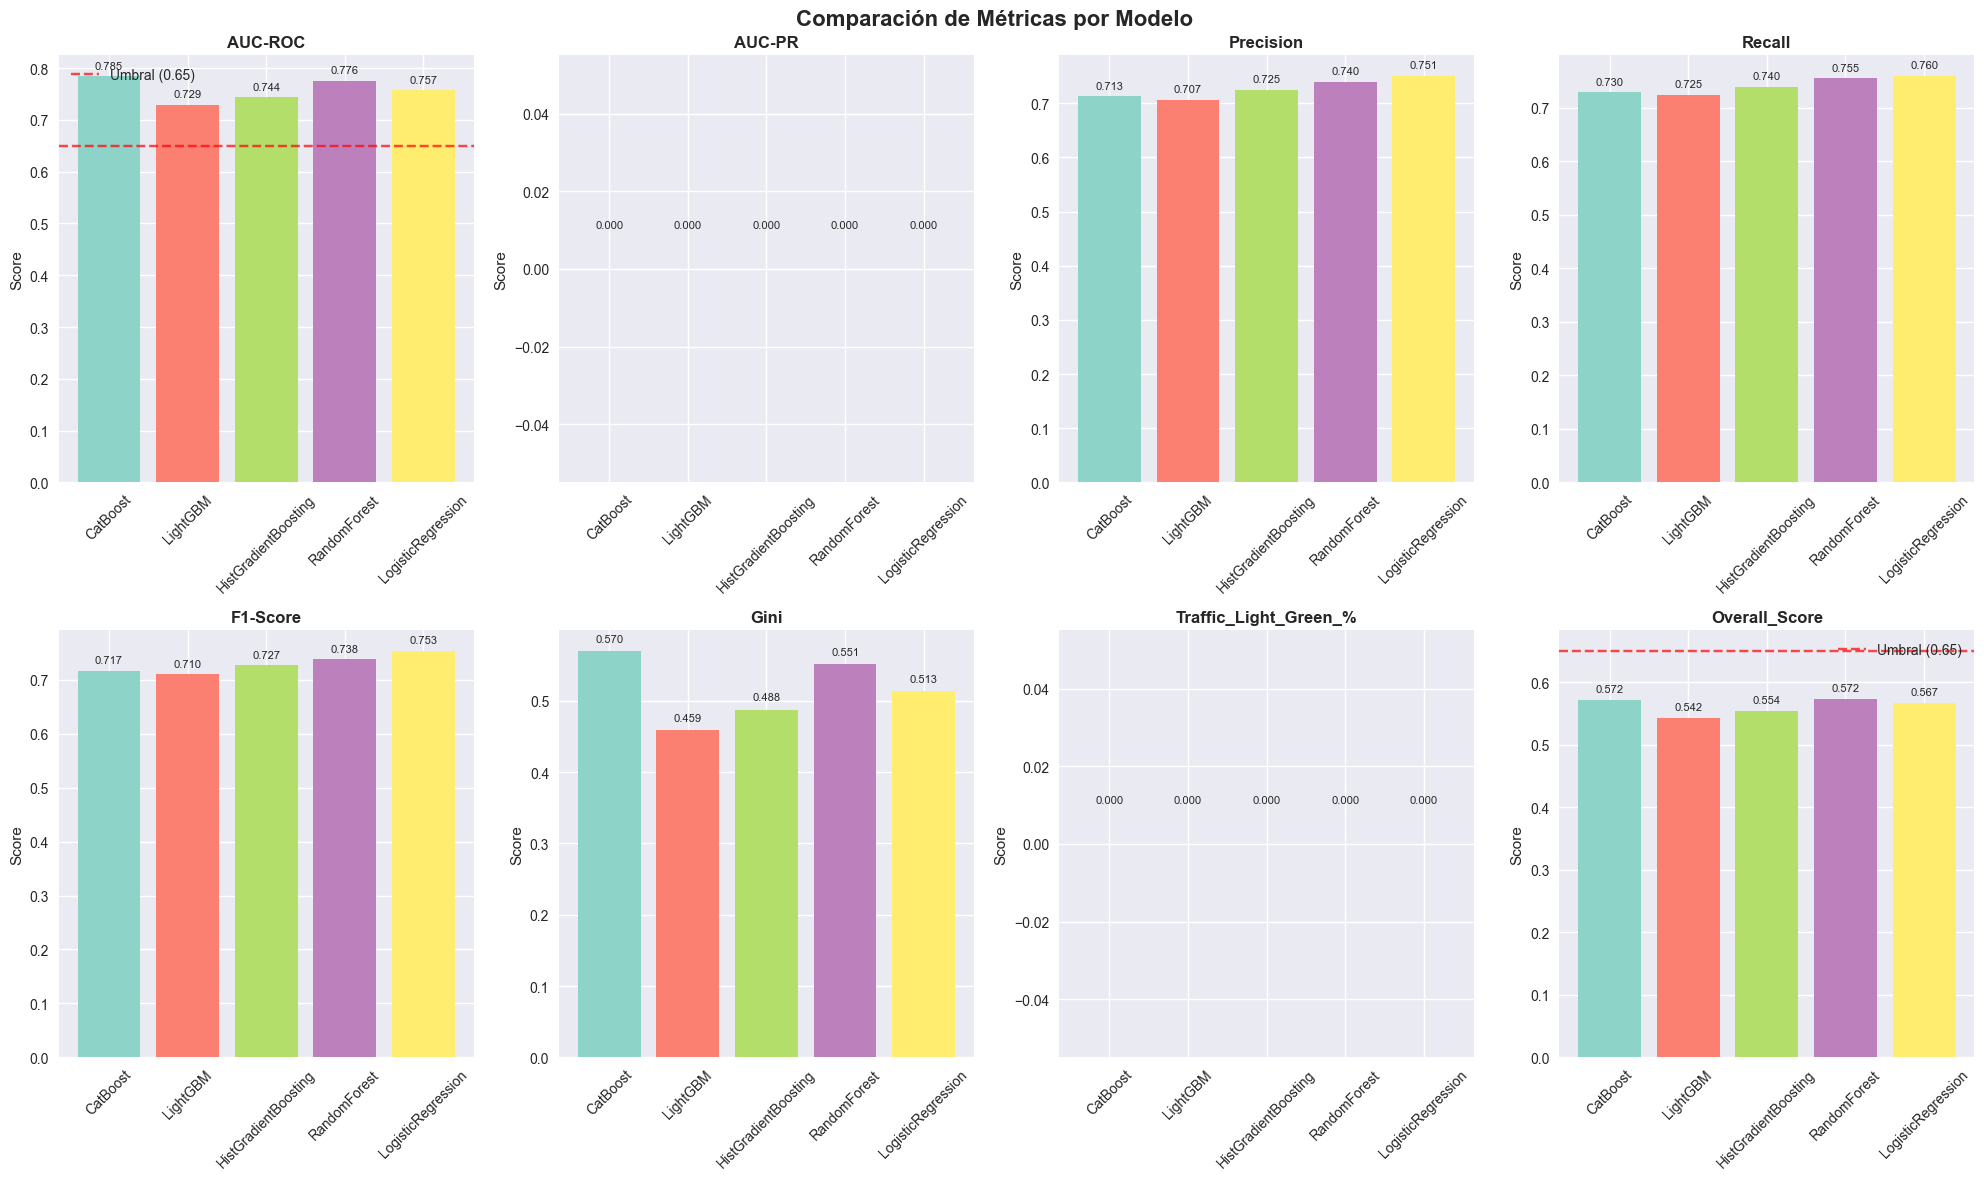


🔥 HEATMAP DE CORRELACIÓN ENTRE MÉTRICAS:
--------------------------------------------------


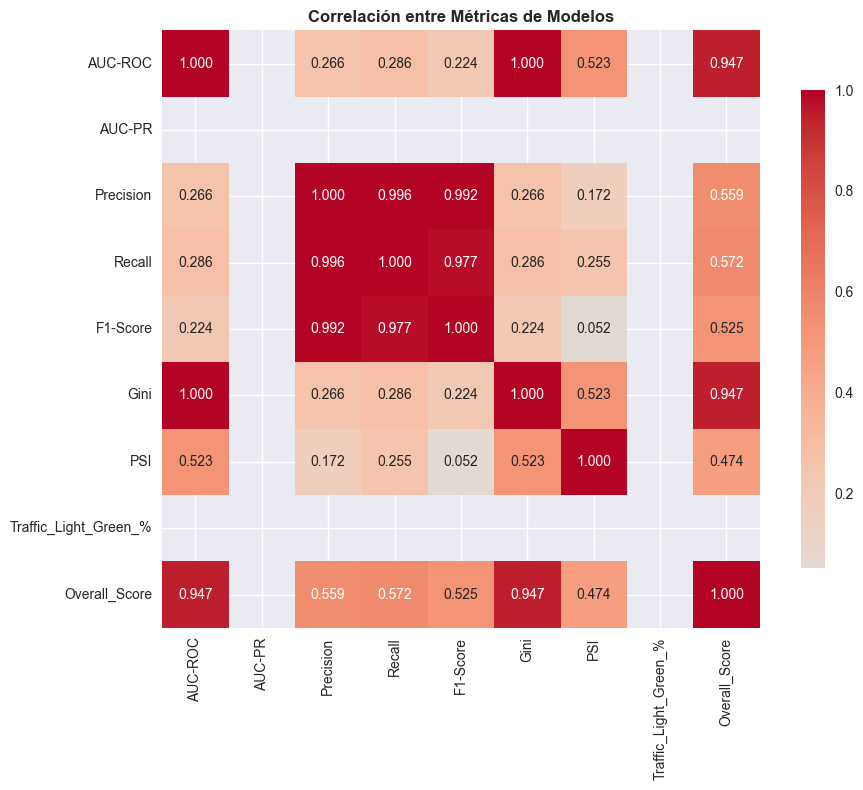


📈 CORRELACIONES MÁS ALTAS:
Métrica 1     Métrica 2  Correlación
  AUC-ROC          Gini     1.000000
Precision        Recall     0.995893
Precision      F1-Score     0.992302
   Recall      F1-Score     0.977129
     Gini Overall_Score     0.947092
  AUC-ROC Overall_Score     0.947092
   Recall Overall_Score     0.571933
Precision Overall_Score     0.559282
 F1-Score Overall_Score     0.525113
  AUC-ROC           PSI     0.523259

✅ Visualizaciones completadas


In [14]:
# Visualización de métricas
if 'metrics_df' in locals() and metrics_df is not None:
    print("📊 CREANDO VISUALIZACIONES DE MÉTRICAS...")
    
    # Configurar el tamaño de las figuras
    plt.rcParams['figure.figsize'] = (15, 10)
    
    # Crear subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    fig.suptitle('Comparación de Métricas por Modelo', fontsize=16, fontweight='bold')
    
    # Métricas a visualizar
    metrics_to_plot = ['AUC-ROC', 'AUC-PR', 'Precision', 'Recall', 
                      'F1-Score', 'Gini', 'Traffic_Light_Green_%', 'Overall_Score']
    
    # Colores para cada modelo
    colors = plt.cm.Set3(np.linspace(0, 1, len(metrics_df)))
    
    for i, metric in enumerate(metrics_to_plot):
        if metric in metrics_df.columns:
            row = i // 4
            col = i % 4
            ax = axes[row, col]
            
            # Crear gráfico de barras
            bars = ax.bar(metrics_df['Modelo'], metrics_df[metric], color=colors)
            ax.set_title(f'{metric}', fontweight='bold')
            ax.set_ylabel('Score')
            ax.tick_params(axis='x', rotation=45)
            
            # Agregar valores en las barras
            for bar, value in zip(bars, metrics_df[metric]):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=8)
            
            # Línea de referencia para métricas importantes
            if metric in ['AUC-ROC', 'Overall_Score']:
                ax.axhline(y=0.65, color='red', linestyle='--', alpha=0.7, label='Umbral (0.65)')
                ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Crear heatmap de correlación entre métricas
    print("\n🔥 HEATMAP DE CORRELACIÓN ENTRE MÉTRICAS:")
    print("-" * 50)
    
    # Seleccionar solo las columnas numéricas
    numeric_metrics = metrics_df.select_dtypes(include=[np.number])
    
    if len(numeric_metrics.columns) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = numeric_metrics.corr()
        
        # Crear heatmap
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
        plt.title('Correlación entre Métricas de Modelos', fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Mostrar correlaciones más altas
        print("\n📈 CORRELACIONES MÁS ALTAS:")
        # Obtener pares de correlación (sin duplicados)
        corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_pairs.append({
                    'Métrica 1': correlation_matrix.columns[i],
                    'Métrica 2': correlation_matrix.columns[j],
                    'Correlación': correlation_matrix.iloc[i, j]
                })
        
        corr_df = pd.DataFrame(corr_pairs)
        corr_df = corr_df.sort_values('Correlación', key=abs, ascending=False)
        
        print(corr_df.head(10).to_string(index=False))
    
    print("\n✅ Visualizaciones completadas")
    
else:
    print("❌ No hay datos de métricas disponibles para visualizar")


🏆 ANÁLISIS DEL MEJOR MODELO...
🥇 Mejor modelo: RandomForest
📊 Overall Score: 0.5722

📈 MÉTRICAS DETALLADAS DE RANDOMFOREST:
------------------------------------------------------------
   AUC-ROC: 0.7757
   AUC-PR: 0.0000
   Precision: 0.7401
   Recall: 0.7550
   F1-Score: 0.7376
   Gini: 0.5514
   PSI: 1.3859
   Traffic_Light_Green_%: 0.0000
   Overall_Score: 0.5722

🔍 ANÁLISIS DE IMPORTANCIA DE FEATURES:
------------------------------------------------------------
   Top 10 features más importantes:
    1. Attribute5: 0.1156
    2. Attribute1_x_Attribute2: 0.0878
    3. Attribute13: 0.0831
    4. Attribute2: 0.0726
    5. Attribute1: 0.0720
    6. Attribute7: 0.0598
    7. Attribute4: 0.0559
    8. Attribute6: 0.0511
    9. Attribute3: 0.0504
   10. Attribute1_squared: 0.0458


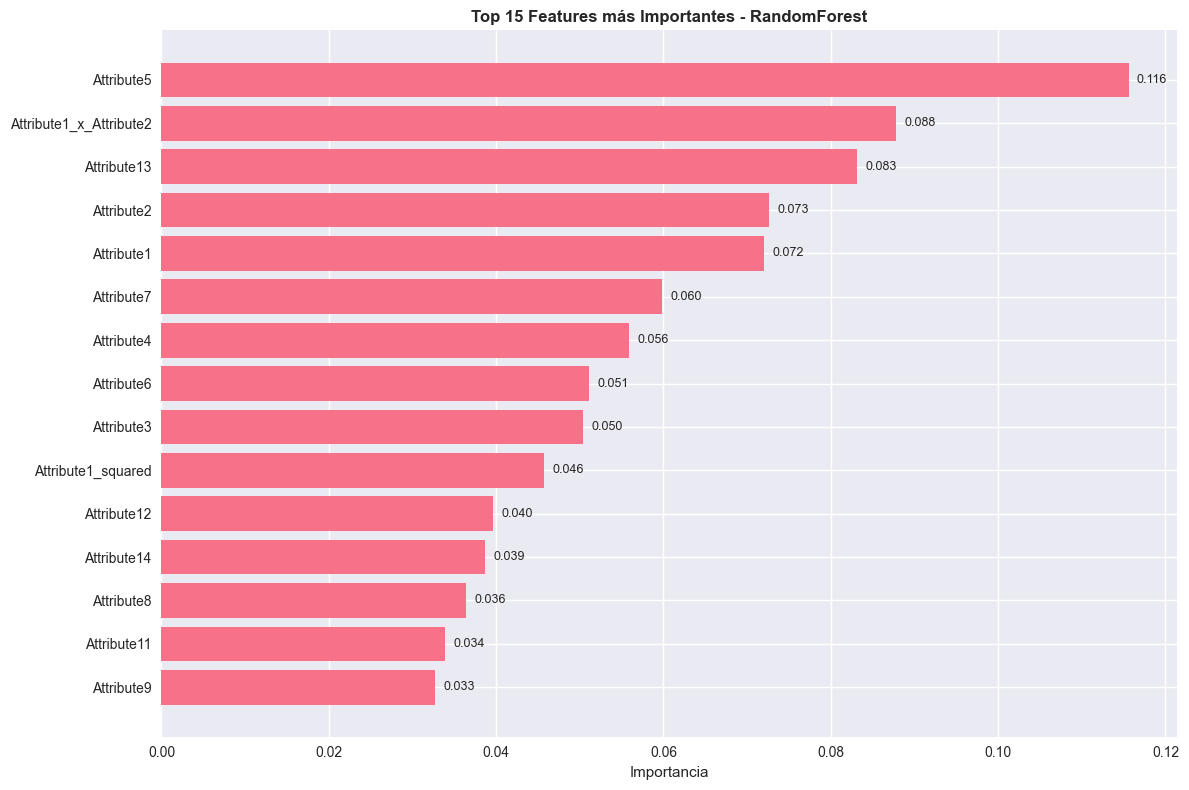

2025-10-17 13:54:19,513 - INFO - Validación cruzada de RandomForest
2025-10-17 13:54:19,513 - INFO - Realizando validación cruzada con 5 folds



🔄 VALIDACIÓN CRUZADA DE RANDOMFOREST:
------------------------------------------------------------


2025-10-17 13:54:21,671 - INFO - CV completado: roc_auc = 0.7707 ± 0.0415
2025-10-17 13:54:21,673 - INFO - CV completado para RandomForest: roc_auc = 0.7707


   CV Score (AUC-ROC): 0.7707 ± 0.0415
   Folds: 5
   Scores por fold: ['0.7497', '0.8403', '0.7619', '0.7156', '0.7860']

🎯 EVALUACIÓN CONTRA UMBRALES DEL PROYECTO:
------------------------------------------------------------
   AUC-ROC: 0.7757 (Umbral: 0.65) - ✅ EXCELENTE
   PSI: 1.3859 (Máximo: 0.1) - ❌ INESTABLE
   Traffic_Light_Green_%: 0.0000 (Mínimo: 0.8) - ❌ NECESITA MEJORA

✅ Análisis del mejor modelo completado


In [15]:
# Análisis detallado del mejor modelo
if 'metrics_df' in locals() and metrics_df is not None:
    print("🏆 ANÁLISIS DEL MEJOR MODELO...")
    
    # Obtener el mejor modelo por Overall Score
    best_model_name = metrics_df.loc[metrics_df['Overall_Score'].idxmax(), 'Modelo']
    best_model_score = metrics_df.loc[metrics_df['Overall_Score'].idxmax(), 'Overall_Score']
    
    print(f"🥇 Mejor modelo: {best_model_name}")
    print(f"📊 Overall Score: {best_model_score:.4f}")
    
    # Obtener el modelo del factory
    best_model = model_factory.models[best_model_name]
    
    # Mostrar métricas detalladas del mejor modelo
    print(f"\n📈 MÉTRICAS DETALLADAS DE {best_model_name.upper()}:")
    print("-" * 60)
    
    best_model_metrics = metrics_df[metrics_df['Modelo'] == best_model_name].iloc[0]
    
    for metric, value in best_model_metrics.items():
        if metric != 'Modelo':
            print(f"   {metric}: {value:.4f}")
    
    # Análisis de importancia de features
    print(f"\n🔍 ANÁLISIS DE IMPORTANCIA DE FEATURES:")
    print("-" * 60)
    
    try:
        feature_importance = best_model.get_feature_importance()
        
        if feature_importance is not None:
            print(f"   Top 10 features más importantes:")
            for i, (feature, importance) in enumerate(feature_importance.head(10).items(), 1):
                print(f"   {i:2d}. {feature}: {importance:.4f}")
            
            # Visualizar importancia de features
            plt.figure(figsize=(12, 8))
            top_features = feature_importance.head(15)
            
            bars = plt.barh(range(len(top_features)), top_features.values)
            plt.yticks(range(len(top_features)), top_features.index)
            plt.xlabel('Importancia')
            plt.title(f'Top 15 Features más Importantes - {best_model_name}', fontweight='bold')
            plt.gca().invert_yaxis()
            
            # Agregar valores en las barras
            for i, (bar, value) in enumerate(zip(bars, top_features.values)):
                plt.text(value + 0.001, i, f'{value:.3f}', 
                        va='center', ha='left', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
        else:
            print(f"   ⚠️ El modelo {best_model_name} no soporta análisis de importancia de features")
            
    except Exception as e:
        print(f"   ❌ Error obteniendo importancia de features: {e}")
    
    # Cross-validation del mejor modelo
    print(f"\n🔄 VALIDACIÓN CRUZADA DE {best_model_name.upper()}:")
    print("-" * 60)
    
    try:
        cv_results = model_factory.cross_validate_model(best_model, X_train, y_train, 'roc_auc')
        
        print(f"   CV Score (AUC-ROC): {cv_results['mean_score']:.4f} ± {cv_results['std_score']:.4f}")
        print(f"   Folds: {cv_results['cv_folds']}")
        print(f"   Scores por fold: {[f'{score:.4f}' for score in cv_results['cv_scores']]}")
        
    except Exception as e:
        print(f"   ❌ Error en validación cruzada: {e}")
    
    # Comparación con umbrales del proyecto
    print(f"\n🎯 EVALUACIÓN CONTRA UMBRALES DEL PROYECTO:")
    print("-" * 60)
    
    # Umbrales definidos en el proyecto
    thresholds = {
        'AUC-ROC': {'minimum': 0.65, 'target': 0.75},
        'PSI': {'maximum': 0.10, 'warning': 0.05},
        'Traffic_Light_Green_%': {'minimum_green': 0.8}
    }
    
    for metric, threshold_info in thresholds.items():
        if metric in best_model_metrics:
            value = best_model_metrics[metric]
            
            if metric == 'AUC-ROC':
                if value >= threshold_info['target']:
                    status = "✅ EXCELENTE"
                elif value >= threshold_info['minimum']:
                    status = "✅ ACEPTABLE"
                else:
                    status = "❌ INSUFICIENTE"
                print(f"   {metric}: {value:.4f} (Umbral: {threshold_info['minimum']}) - {status}")
                
            elif metric == 'PSI':
                if value <= threshold_info['warning']:
                    status = "✅ ESTABLE"
                elif value <= threshold_info['maximum']:
                    status = "⚠️ ADVERTENCIA"
                else:
                    status = "❌ INESTABLE"
                print(f"   {metric}: {value:.4f} (Máximo: {threshold_info['maximum']}) - {status}")
                
            elif metric == 'Traffic_Light_Green_%':
                if value >= threshold_info['minimum_green']:
                    status = "✅ BUENO"
                else:
                    status = "❌ NECESITA MEJORA"
                print(f"   {metric}: {value:.4f} (Mínimo: {threshold_info['minimum_green']}) - {status}")
    
    print(f"\n✅ Análisis del mejor modelo completado")
    
else:
    print("❌ No hay datos de métricas disponibles para análisis")


In [16]:
# Resumen ejecutivo y conclusiones
if 'metrics_df' in locals() and metrics_df is not None:
    print("📋 RESUMEN EJECUTIVO Y CONCLUSIONES")
    print("="*80)
    
    # Estadísticas generales
    print("\n📊 ESTADÍSTICAS GENERALES:")
    print("-" * 40)
    print(f"   Total de modelos evaluados: {len(metrics_df)}")
    print(f"   Mejor Overall Score: {metrics_df['Overall_Score'].max():.4f}")
    print(f"   Peor Overall Score: {metrics_df['Overall_Score'].min():.4f}")
    print(f"   Promedio Overall Score: {metrics_df['Overall_Score'].mean():.4f}")
    print(f"   Desviación estándar: {metrics_df['Overall_Score'].std():.4f}")
    
    # Top 3 modelos
    print(f"\n🏆 TOP 3 MODELOS:")
    print("-" * 40)
    top_3 = metrics_df.nlargest(3, 'Overall_Score')
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        print(f"   {i}. {row['Modelo']}: {row['Overall_Score']:.4f}")
    
    # Análisis por tipo de modelo
    print(f"\n🔍 ANÁLISIS POR TIPO DE MODELO:")
    print("-" * 40)
    
    # Clasificar modelos por tipo
    model_types = {
        'Gradient Boosting': ['XGBoost', 'CatBoost', 'LightGBM', 'HistGradientBoosting'],
        'Tree-based': ['RandomForest'],
        'Linear': ['LogisticRegression']
    }
    
    for model_type, model_names in model_types.items():
        type_models = metrics_df[metrics_df['Modelo'].isin(model_names)]
        if len(type_models) > 0:
            avg_score = type_models['Overall_Score'].mean()
            best_in_type = type_models.loc[type_models['Overall_Score'].idxmax(), 'Modelo']
            print(f"   {model_type}:")
            print(f"      Promedio: {avg_score:.4f}")
            print(f"      Mejor: {best_in_type} ({type_models['Overall_Score'].max():.4f})")
            print(f"      Modelos: {len(type_models)}")
    
    # Cumplimiento de umbrales
    print(f"\n🎯 CUMPLIMIENTO DE UMBRALES:")
    print("-" * 40)
    
    # Contar modelos que cumplen umbrales
    auc_threshold = 0.65
    psi_threshold = 0.10
    
    models_above_auc = len(metrics_df[metrics_df['AUC-ROC'] >= auc_threshold])
    models_below_psi = len(metrics_df[metrics_df['PSI'] <= psi_threshold])
    
    print(f"   Modelos con AUC ≥ {auc_threshold}: {models_above_auc}/{len(metrics_df)} ({models_above_auc/len(metrics_df)*100:.1f}%)")
    print(f"   Modelos con PSI ≤ {psi_threshold}: {models_below_psi}/{len(metrics_df)} ({models_below_psi/len(metrics_df)*100:.1f}%)")
    
    # Modelos que cumplen ambos umbrales
    both_thresholds = metrics_df[
        (metrics_df['AUC-ROC'] >= auc_threshold) & 
        (metrics_df['PSI'] <= psi_threshold)
    ]
    print(f"   Modelos que cumplen ambos umbrales: {len(both_thresholds)}/{len(metrics_df)} ({len(both_thresholds)/len(metrics_df)*100:.1f}%)")
    
    # Recomendaciones
    print(f"\n💡 RECOMENDACIONES:")
    print("-" * 40)
    
    best_model_name = metrics_df.loc[metrics_df['Overall_Score'].idxmax(), 'Modelo']
    best_auc = metrics_df['AUC-ROC'].max()
    best_psi = metrics_df['PSI'].min()
    
    print(f"   1. Modelo recomendado: {best_model_name}")
    print(f"   2. Mejor AUC-ROC: {best_auc:.4f} ({'✅ Cumple' if best_auc >= 0.65 else '❌ No cumple'} umbral)")
    print(f"   3. Mejor PSI: {best_psi:.4f} ({'✅ Estable' if best_psi <= 0.10 else '❌ Inestable'})")
    
    if best_auc < 0.65:
        print(f"   4. ⚠️ Ningún modelo alcanza el umbral mínimo de AUC (0.65)")
        print(f"      Considerar: Feature engineering, más datos, o modelos más complejos")
    
    if best_psi > 0.10:
        print(f"   5. ⚠️ Algunos modelos muestran inestabilidad (PSI > 0.10)")
        print(f"      Considerar: Regularización, validación cruzada más robusta")
    
    # Próximos pasos
    print(f"\n🚀 PRÓXIMOS PASOS SUGERIDOS:")
    print("-" * 40)
    print(f"   1. Implementar el mejor modelo ({best_model_name}) en producción")
    print(f"   2. Realizar validación con datos fuera de tiempo (OOT)")
    print(f"   3. Implementar monitoreo de estabilidad (PSI)")
    print(f"   4. Considerar ensemble de los top 3 modelos")
    print(f"   5. Experimentar con datos sintéticos para mejorar performance")
    
    print(f"\n✅ Análisis completo finalizado")
    
else:
    print("❌ No hay datos disponibles para resumen ejecutivo")


📋 RESUMEN EJECUTIVO Y CONCLUSIONES

📊 ESTADÍSTICAS GENERALES:
----------------------------------------
   Total de modelos evaluados: 5
   Mejor Overall Score: 0.5722
   Peor Overall Score: 0.5422
   Promedio Overall Score: 0.5613
   Desviación estándar: 0.0130

🏆 TOP 3 MODELOS:
----------------------------------------
   1. RandomForest: 0.5722
   2. CatBoost: 0.5716
   3. LogisticRegression: 0.5666

🔍 ANÁLISIS POR TIPO DE MODELO:
----------------------------------------
   Gradient Boosting:
      Promedio: 0.5558
      Mejor: CatBoost (0.5716)
      Modelos: 3
   Tree-based:
      Promedio: 0.5722
      Mejor: RandomForest (0.5722)
      Modelos: 1
   Linear:
      Promedio: 0.5666
      Mejor: LogisticRegression (0.5666)
      Modelos: 1

🎯 CUMPLIMIENTO DE UMBRALES:
----------------------------------------
   Modelos con AUC ≥ 0.65: 5/5 (100.0%)
   Modelos con PSI ≤ 0.1: 0/5 (0.0%)
   Modelos que cumplen ambos umbrales: 0/5 (0.0%)

💡 RECOMENDACIONES:
-------------------------------

## 🎯 Próximos Pasos: Integración con Datos Sintéticos

Ahora que hemos establecido una línea base sólida con los modelos de ML, el siguiente paso es integrar los datos sintéticos generados en la Fase 2 para mejorar el performance de los modelos.

### 📋 Plan de Integración:

1. **Cargar datos sintéticos generados** desde la Fase 2
2. **Combinar datos reales y sintéticos** para entrenamiento
3. **Re-entrenar modelos** con datos combinados
4. **Comparar performance** entre modelos entrenados solo con datos reales vs. datos combinados
5. **Evaluar calidad de datos sintéticos** usando métricas específicas
6. **Implementar estrategias de Domain Generalization**

### 🔄 Estrategias de Combinación:

- **Estrategia 1**: 70% datos reales + 30% datos sintéticos
- **Estrategia 2**: 50% datos reales + 50% datos sintéticos  
- **Estrategia 3**: 30% datos reales + 70% datos sintéticos
- **Estrategia 4**: Solo datos sintéticos (validación extrema)

### 📊 Métricas de Evaluación Adicionales:

- **Kolmogorov-Smirnov Complement** para comparar distribuciones
- **Chi-Squared test** para independencia
- **Kullback-Leibler Divergence** para similitud
- **Cosine Similarity** para correlación
- **Jensen-Shannon Entropy** para diversidad

¿Estás listo para proceder con la integración de datos sintéticos? 🚀


In [6]:
# Crear todos los modelos
models = model_factory.create_all_models()

# Entrenar todos los modelos
trained_models = model_factory.train_all_models(X_train, y_train)

2025-10-17 13:47:43,073 - INFO - Modelo XGBoost inicializado
2025-10-17 13:47:43,077 - INFO - XGBoost configurado
2025-10-17 13:47:43,078 - INFO - Modelo creado: XGBoost
2025-10-17 13:47:43,079 - INFO - Modelo XGBoost creado exitosamente
2025-10-17 13:47:43,081 - INFO - Modelo CatBoost inicializado
2025-10-17 13:47:43,083 - INFO - CatBoost configurado
2025-10-17 13:47:43,084 - INFO - Modelo creado: CatBoost
2025-10-17 13:47:43,085 - INFO - Modelo CatBoost creado exitosamente
2025-10-17 13:47:43,085 - INFO - Modelo LightGBM inicializado
2025-10-17 13:47:43,088 - INFO - LightGBM configurado
2025-10-17 13:47:43,091 - INFO - Modelo creado: LightGBM
2025-10-17 13:47:43,091 - INFO - Modelo LightGBM creado exitosamente
2025-10-17 13:47:43,095 - INFO - Modelo HistGradientBoosting inicializado
2025-10-17 13:47:43,095 - INFO - HistGradientBoosting configurado
2025-10-17 13:47:43,097 - INFO - Modelo creado: HistGradientBoosting
2025-10-17 13:47:43,099 - INFO - Modelo HistGradientBoosting creado e

In [7]:
# Evaluar todos los modelos
results = model_factory.evaluate_all_models(X_test, y_test, X_train, y_train)

# Obtener ranking de modelos
ranking = model_factory.get_model_ranking('overall_score')

2025-10-17 13:48:30,111 - INFO - Evaluando todos los modelos
2025-10-17 13:48:30,118 - WARNING - Modelo XGBoost no está entrenado
2025-10-17 13:48:30,118 - INFO - Evaluando CatBoost...
2025-10-17 13:48:30,120 - INFO - CreditModelEvaluator inicializado con 5 métricas
2025-10-17 13:48:30,123 - INFO - Iniciando evaluación de modelo de scoring crediticio
2025-10-17 13:48:30,152 - WARNING - Error calculando AUC-PR: y_true takes value in {1, 2} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.
2025-10-17 13:48:30,156 - INFO - Métricas básicas calculadas: AUC-ROC = 0.785
2025-10-17 13:48:30,167 - INFO - PSI calculado: 0.4856
2025-10-17 13:48:30,175 - INFO - Traffic Light calculado: 0.0% grupos verdes
2025-10-17 13:48:30,186 - INFO - Estabilidad de población calculada: score = 0.848
2025-10-17 13:48:30,186 - INFO - Métricas de crédito calculadas: 4 métricas
2025-10-17 13:48:30,186 - INFO - Evaluación completada. Score general: 0.57

In [9]:
# Obtener el mejor modelo
best_model = model_factory.get_best_model('overall_score')

# Análisis de importancia de features
feature_importance = best_model.get_feature_importance()

2025-10-17 13:49:05,235 - INFO - Mejor modelo: RandomForest (score: 0.572)


In [10]:


# Crear y entrenar todos los modelos
if splits is not None:
    print("🤖 Creando y entrenando modelos de scoring crediticio...")
    
    # Crear todos los modelos
    models = model_factory.create_all_models()
    print(f"✅ {len(models)} modelos creados: {list(models.keys())}")
    
    # Entrenar todos los modelos
    print("\n🏋️ Entrenando modelos...")
    trained_models = model_factory.train_all_models(X_train, y_train)
    
    print(f"✅ {len(trained_models)} modelos entrenados exitosamente")
    
    # Mostrar resumen de entrenamiento
    training_summary = model_factory.get_training_summary()
    print(f"\n📊 Resumen de entrenamiento:")
    print(f"   Total modelos: {training_summary['total_models']}")
    print(f"   Modelos entrenados: {training_summary['trained_models']}")
    print(f"   Tipos de modelos: {list(training_summary['model_types'].keys())}")
    
else:
    print("❌ No hay datos disponibles para entrenar modelos")
    models = None

2025-10-17 13:51:02,703 - INFO - Modelo XGBoost inicializado
2025-10-17 13:51:02,704 - INFO - XGBoost configurado
2025-10-17 13:51:02,706 - INFO - Modelo creado: XGBoost
2025-10-17 13:51:02,708 - INFO - Modelo XGBoost creado exitosamente
2025-10-17 13:51:02,708 - INFO - Modelo CatBoost inicializado
2025-10-17 13:51:02,710 - INFO - CatBoost configurado
2025-10-17 13:51:02,712 - INFO - Modelo creado: CatBoost
2025-10-17 13:51:02,712 - INFO - Modelo CatBoost creado exitosamente
2025-10-17 13:51:02,712 - INFO - Modelo LightGBM inicializado
2025-10-17 13:51:02,712 - INFO - LightGBM configurado
2025-10-17 13:51:02,720 - INFO - Modelo creado: LightGBM
2025-10-17 13:51:02,721 - INFO - Modelo LightGBM creado exitosamente
2025-10-17 13:51:02,721 - INFO - Modelo HistGradientBoosting inicializado
2025-10-17 13:51:02,721 - INFO - HistGradientBoosting configurado
2025-10-17 13:51:02,721 - INFO - Modelo creado: HistGradientBoosting
2025-10-17 13:51:02,721 - INFO - Modelo HistGradientBoosting creado e

🤖 Creando y entrenando modelos de scoring crediticio...
✅ 6 modelos creados: ['XGBoost', 'CatBoost', 'LightGBM', 'HistGradientBoosting', 'RandomForest', 'LogisticRegression']

🏋️ Entrenando modelos...


2025-10-17 13:51:03,289 - INFO - Modelo CatBoost entrenado exitosamente
2025-10-17 13:51:03,305 - INFO - ✅ CatBoost entrenado exitosamente
2025-10-17 13:51:03,305 - INFO - Entrenando LightGBM...
2025-10-17 13:51:03,305 - INFO - Datos validados: 600 filas, 22 features
2025-10-17 13:51:03,305 - INFO - Entrenando modelo LightGBM
2025-10-17 13:51:03,374 - INFO - Modelo LightGBM entrenado exitosamente
2025-10-17 13:51:03,378 - INFO - ✅ LightGBM entrenado exitosamente
2025-10-17 13:51:03,378 - INFO - Entrenando HistGradientBoosting...
2025-10-17 13:51:03,378 - INFO - Datos validados: 600 filas, 22 features
2025-10-17 13:51:03,378 - INFO - Entrenando modelo HistGradientBoosting
2025-10-17 13:51:03,708 - INFO - Modelo HistGradientBoosting entrenado exitosamente
2025-10-17 13:51:03,708 - INFO - ✅ HistGradientBoosting entrenado exitosamente
2025-10-17 13:51:03,713 - INFO - Entrenando RandomForest...
2025-10-17 13:51:03,715 - INFO - Datos validados: 600 filas, 22 features
2025-10-17 13:51:03,715 

✅ 5 modelos entrenados exitosamente

📊 Resumen de entrenamiento:
   Total modelos: 6
   Modelos entrenados: 5
   Tipos de modelos: ['CreditScoring']


In [11]:


# Evaluar todos los modelos
if models is not None:
    print("📊 Evaluando todos los modelos...")
    
    # Evaluar todos los modelos
    results = model_factory.evaluate_all_models(X_test, y_test, X_train, y_train)
    
    print(f"✅ {len(results)} modelos evaluados exitosamente")
    
    # Mostrar resultados métrica por métrica
    print("\n" + "="*80)
    print("📈 COMPARACIÓN MÉTRICA A MÉTRICA DE TODOS LOS MODELOS")
    print("="*80)
    
    # Crear DataFrame con todas las métricas
    metrics_data = []
    
    for model_name, model_results in results.items():
        row = {'Modelo': model_name}
        
        # Métricas básicas
        if 'basic_metrics' in model_results and 'error' not in model_results['basic_metrics']:
            basic = model_results['basic_metrics']
            row.update({
                'AUC-ROC': basic.get('auc_roc', 0),
                'AUC-PR': basic.get('auc_pr', 0),
                'Precision': basic.get('precision', 0),
                'Recall': basic.get('recall', 0),
                'F1-Score': basic.get('f1_score', 0)
            })
        
        # Métricas de crédito
        if 'credit_metrics' in model_results and 'error' not in model_results['credit_metrics']:
            credit = model_results['credit_metrics']
            row.update({
                'Gini': credit.get('gini_coefficient', 0),
                'PSI': credit.get('psi', 0)
            })
            
            # Traffic Light
            if 'traffic_light' in credit and 'error' not in credit['traffic_light']:
                row['Traffic_Light_Green_%'] = credit['traffic_light'].get('green_percentage', 0)
            else:
                row['Traffic_Light_Green_%'] = 0
        
        # Score general
        row['Overall_Score'] = model_results.get('overall_score', 0)
        
        metrics_data.append(row)
    
    # Crear DataFrame
    metrics_df = pd.DataFrame(metrics_data)
    
    # Mostrar tabla completa
    print("\n📋 TABLA COMPLETA DE MÉTRICAS:")
    print("-" * 80)
    display(metrics_df.round(4))
    
    # Mostrar métricas una por una con ranking
    print("\n🏆 RANKING POR MÉTRICA:")
    print("-" * 80)
    
    # Lista de métricas para ranking
    ranking_metrics = ['AUC-ROC', 'AUC-PR', 'Precision', 'Recall', 'F1-Score', 
                      'Gini', 'Traffic_Light_Green_%', 'Overall_Score']
    
    for metric in ranking_metrics:
        if metric in metrics_df.columns:
            print(f"\n🥇 {metric.upper()}:")
            sorted_models = metrics_df.sort_values(metric, ascending=False)
            for i, (_, row) in enumerate(sorted_models.iterrows(), 1):
                print(f"   {i}. {row['Modelo']}: {row[metric]:.4f}")
    
    # Guardar resultados
    print(f"\n💾 Resultados guardados en memoria para análisis posterior")
    
else:
    print("❌ No hay modelos disponibles para evaluar")
    results = None

2025-10-17 13:51:18,944 - INFO - Evaluando todos los modelos
2025-10-17 13:51:18,944 - WARNING - Modelo XGBoost no está entrenado
2025-10-17 13:51:18,944 - INFO - Evaluando CatBoost...
2025-10-17 13:51:18,944 - INFO - CreditModelEvaluator inicializado con 5 métricas
2025-10-17 13:51:18,944 - INFO - Iniciando evaluación de modelo de scoring crediticio
2025-10-17 13:51:18,980 - WARNING - Error calculando AUC-PR: y_true takes value in {1, 2} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.
2025-10-17 13:51:18,980 - INFO - Métricas básicas calculadas: AUC-ROC = 0.785
2025-10-17 13:51:18,992 - INFO - PSI calculado: 0.4856
2025-10-17 13:51:19,000 - INFO - Traffic Light calculado: 0.0% grupos verdes
2025-10-17 13:51:19,008 - INFO - Estabilidad de población calculada: score = 0.848
2025-10-17 13:51:19,008 - INFO - Métricas de crédito calculadas: 4 métricas
2025-10-17 13:51:19,008 - INFO - Evaluación completada. Score general: 0.57

📊 Evaluando todos los modelos...


2025-10-17 13:51:19,159 - INFO - Estabilidad de población calculada: score = 0.888
2025-10-17 13:51:19,195 - INFO - Métricas de crédito calculadas: 4 métricas
2025-10-17 13:51:19,199 - INFO - Evaluación completada. Score general: 0.542
2025-10-17 13:51:19,201 - INFO - Modelo LightGBM evaluado exitosamente
2025-10-17 13:51:19,203 - INFO - ✅ LightGBM evaluado exitosamente
2025-10-17 13:51:19,212 - INFO - Evaluando HistGradientBoosting...
2025-10-17 13:51:19,214 - INFO - CreditModelEvaluator inicializado con 5 métricas
2025-10-17 13:51:19,216 - INFO - Iniciando evaluación de modelo de scoring crediticio
2025-10-17 13:51:19,508 - WARNING - Error calculando AUC-PR: y_true takes value in {1, 2} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.
2025-10-17 13:51:19,508 - INFO - Métricas básicas calculadas: AUC-ROC = 0.744
2025-10-17 13:51:19,537 - INFO - PSI calculado: 0.2420
2025-10-17 13:51:19,542 - INFO - Traffic Light calculado

✅ 5 modelos evaluados exitosamente

📈 COMPARACIÓN MÉTRICA A MÉTRICA DE TODOS LOS MODELOS

📋 TABLA COMPLETA DE MÉTRICAS:
--------------------------------------------------------------------------------


,Modelo,AUC-ROC,AUC-PR,Precision,Recall,F1-Score,Gini,PSI,Traffic_Light_Green_%,Overall_Score
0,CatBoost,0.7850,0.0,0.7134,0.730,0.7165,0.5700,0.4856,0.0,0.5716
1,LightGBM,0.7294,0.0,0.7069,0.725,0.7102,0.4588,0.3366,0.0,0.5422
2,HistGradientBoosting,0.7438,0.0,0.7247,0.740,0.7270,0.4876,0.2420,0.0,0.5537
3,RandomForest,0.7757,0.0,0.7401,0.755,0.7376,0.5514,1.3859,0.0,0.5722
4,LogisticRegression,0.7567,0.0,0.7507,0.760,0.7532,0.5133,0.1063,0.0,0.5666



🏆 RANKING POR MÉTRICA:
--------------------------------------------------------------------------------

🥇 AUC-ROC:
   1. CatBoost: 0.7850
   2. RandomForest: 0.7757
   3. LogisticRegression: 0.7567
   4. HistGradientBoosting: 0.7438
   5. LightGBM: 0.7294

🥇 AUC-PR:
   1. CatBoost: 0.0000
   2. LightGBM: 0.0000
   3. HistGradientBoosting: 0.0000
   4. RandomForest: 0.0000
   5. LogisticRegression: 0.0000

🥇 PRECISION:
   1. LogisticRegression: 0.7507
   2. RandomForest: 0.7401
   3. HistGradientBoosting: 0.7247
   4. CatBoost: 0.7134
   5. LightGBM: 0.7069

🥇 RECALL:
   1. LogisticRegression: 0.7600
   2. RandomForest: 0.7550
   3. HistGradientBoosting: 0.7400
   4. CatBoost: 0.7300
   5. LightGBM: 0.7250

🥇 F1-SCORE:
   1. LogisticRegression: 0.7532
   2. RandomForest: 0.7376
   3. HistGradientBoosting: 0.7270
   4. CatBoost: 0.7165
   5. LightGBM: 0.7102

🥇 GINI:
   1. CatBoost: 0.5700
   2. RandomForest: 0.5514
   3. LogisticRegression: 0.5133
   4. HistGradientBoosting: 0.4876
  